## Source
https://www.azlyrics.com/m/mayer.html

In [78]:
from __future__ import absolute_import, division, print_function

In [79]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [80]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [81]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bmartins/workspace/virtualenv_python3.5/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


**Set up logging**

In [82]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [83]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/bmartins/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bmartins/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

In [84]:
lyrics_filenames = sorted(glob.glob("data/*.txt"))

In [85]:
print("Found lyrics:")
lyrics_filenames

Found lyrics:


['data/3x5.txt',
 'data/83.txt',
 'data/a_break_in_the_clouds.txt',
 'data/a_face_to_call_home.txt',
 'data/all_we_ever_do_is_say_goodbye.txt',
 'data/another_kind_of_green.txt',
 'data/assassin.txt',
 'data/back_to_you.txt',
 'data/badge_and_gun.txt',
 'data/belief.txt',
 'data/bigger_than_my_body.txt',
 'data/bold_as_love.txt',
 'data/born_and_raised.txt',
 'data/call_me_the_breeze.txt',
 'data/changing.txt',
 'data/city_love.txt',
 'data/clarity.txt',
 'data/come_back_to_bed.txt',
 'data/comfortable.txt',
 'data/covered_in_rain.txt',
 'data/crossroads.txt',
 'data/daughters.txt',
 'data/dear_marie.txt',
 'data/do_you_know_me.txt',
 'data/dreaming_with_a_broken_heart.txt',
 'data/edge_of_desire.txt',
 'data/emoji_of_a_wave.txt',
 'data/everyday_i_have_the_blues.txt',
 'data/everything_youll_ever_be.txt',
 'data/fool_to_love_you.txt',
 'data/friends_lovers_or_nothing.txt',
 'data/go_easy_on_me.txt',
 'data/good_love_is_on_the_way.txt',
 'data/gravity.txt',
 'data/great_indoors.txt',
 

**Combine the lyrics into one string**

In [86]:
corpus_raw = u""
for lyric_filename in lyrics_filenames:
    print("Reading '{0}'...".format(lyric_filename))
    with codecs.open(lyric_filename, "r", "utf-8") as lyric_file:
        corpus_raw += lyric_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data/3x5.txt'...
Corpus is now 1153 characters long

Reading 'data/83.txt'...
Corpus is now 2667 characters long

Reading 'data/a_break_in_the_clouds.txt'...
Corpus is now 4257 characters long

Reading 'data/a_face_to_call_home.txt'...
Corpus is now 5734 characters long

Reading 'data/all_we_ever_do_is_say_goodbye.txt'...
Corpus is now 6667 characters long

Reading 'data/another_kind_of_green.txt'...
Corpus is now 7875 characters long

Reading 'data/assassin.txt'...
Corpus is now 9423 characters long

Reading 'data/back_to_you.txt'...
Corpus is now 10225 characters long

Reading 'data/badge_and_gun.txt'...
Corpus is now 11316 characters long

Reading 'data/belief.txt'...
Corpus is now 12516 characters long

Reading 'data/bigger_than_my_body.txt'...
Corpus is now 13801 characters long

Reading 'data/bold_as_love.txt'...
Corpus is now 14716 characters long

Reading 'data/born_and_raised.txt'...
Corpus is now 15674 characters long

Reading 'data/call_me_the_breeze.txt'...
Corpus 

**Split the corpus into sentences**

In [87]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [88]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [89]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [90]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [91]:
print(raw_sentences[15])
print(sentence_to_wordlist(raw_sentences[15]))

It's the same she's been standing in
Since the day she saw him walking away
Now she's left
Cleaning up the mess he made

So fathers, be good to your daughters
Daughters will love like you do
Girls become lovers who turn into mothers
So mothers, be good to your daughters too

Boys, you can break
You find out how much they can take
Boys will be strong
And boys soldier on
But boys would be gone without the warmth from
A woman's good, good heart

On behalf of every man
Looking out for every girl
You are the god and the weight of her world

So fathers, be good to your daughters
Daughters will love like you do
Girls become lovers who turn into mothers
So mothers, be good to your daughters too
Dear Marie,
Tell me what it was I used to be?
['It', 's', 'the', 'same', 'she', 's', 'been', 'standing', 'in', 'Since', 'the', 'day', 'she', 'saw', 'him', 'walking', 'away', 'Now', 'she', 's', 'left', 'Cleaning', 'up', 'the', 'mess', 'he', 'made', 'So', 'fathers', 'be', 'good', 'to', 'your', 'daughters'

In [92]:
token_count = sum([len(sentence) for sentence in sentences])
print("The lyrics corpus contains {0:,} tokens".format(token_count))

The lyrics corpus contains 23,218 tokens


## Train Word2Vec

In [93]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [94]:
w2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [95]:
w2vec.build_vocab(sentences)

2017-11-24 08:41:34,144 : INFO : collecting all words and their counts
2017-11-24 08:41:34,146 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-11-24 08:41:34,150 : INFO : collected 2280 word types from a corpus of 23218 raw words and 255 sentences
2017-11-24 08:41:34,155 : INFO : min_count=3 retains 966 unique words (drops 1314)
2017-11-24 08:41:34,156 : INFO : min_count leaves 21603 word corpus (93% of original 23218)
2017-11-24 08:41:34,160 : INFO : deleting the raw counts dictionary of 2280 items
2017-11-24 08:41:34,161 : INFO : sample=0.001 downsamples 75 most-common words
2017-11-24 08:41:34,162 : INFO : downsampling leaves estimated 14767 word corpus (68.4% of prior 21603)
2017-11-24 08:41:34,162 : INFO : estimated required memory for 966 words and 300 dimensions: 2801400 bytes
2017-11-24 08:41:34,166 : INFO : resetting layer weights


In [96]:
print("Word2Vec vocabulary length:", len(w2vec.vocab))

Word2Vec vocabulary length: 966


**Start training, this might take a minute or two...**

In [97]:
w2vec.train(sentences)

2017-11-24 08:41:34,196 : INFO : training model with 8 workers on 966 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5
2017-11-24 08:41:34,197 : INFO : expecting 255 sentences, matching count from corpus used for vocabulary survey
2017-11-24 08:41:34,335 : INFO : worker thread finished; awaiting finish of 7 more threads
2017-11-24 08:41:34,336 : INFO : worker thread finished; awaiting finish of 6 more threads
2017-11-24 08:41:34,341 : INFO : worker thread finished; awaiting finish of 5 more threads
2017-11-24 08:41:34,345 : INFO : worker thread finished; awaiting finish of 4 more threads
2017-11-24 08:41:34,377 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-11-24 08:41:34,388 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-11-24 08:41:34,404 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-11-24 08:41:34,405 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-11-24 08:41:34,4

73672

**Save to file, can be useful later**

In [98]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [99]:
w2vec.save(os.path.join("trained", "lyrics2vec.w2v"))

2017-11-24 08:41:34,427 : INFO : saving Word2Vec object under trained/lyrics2vec.w2v, separately None
2017-11-24 08:41:34,429 : INFO : not storing attribute cum_table
2017-11-24 08:41:34,430 : INFO : not storing attribute syn0norm


## Explore the trained model.

In [100]:
w2vec = w2v.Word2Vec.load(os.path.join("trained", "lyrics2vec.w2v"))

2017-11-24 08:41:34,454 : INFO : loading Word2Vec object from trained/lyrics2vec.w2v
2017-11-24 08:41:34,471 : INFO : setting ignored attribute cum_table to None
2017-11-24 08:41:34,472 : INFO : setting ignored attribute syn0norm to None


### Compress the word vectors into 2D space and plot them

In [101]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [102]:
all_word_vectors_matrix = w2vec.syn0

**Train t-SNE, this could take a minute or two...**

In [103]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [104]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[w2vec.vocab[word].index])
            for word in w2vec.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [105]:
points.head(10)

,word,x,y
0,says,-3.812027,-21.814618
1,happened,0.269097,17.084843
2,Two,1.766016,-13.757073
3,own,1.437139,-28.585949
4,right,-6.680349,-9.385667
5,Hard,-8.528490,13.193792
6,wheel,0.938047,-18.217091
7,stand,9.347710,7.280560
8,herself,-11.870348,7.699460
9,Sleep,10.039737,19.549850


In [106]:
sns.set_context("poster")

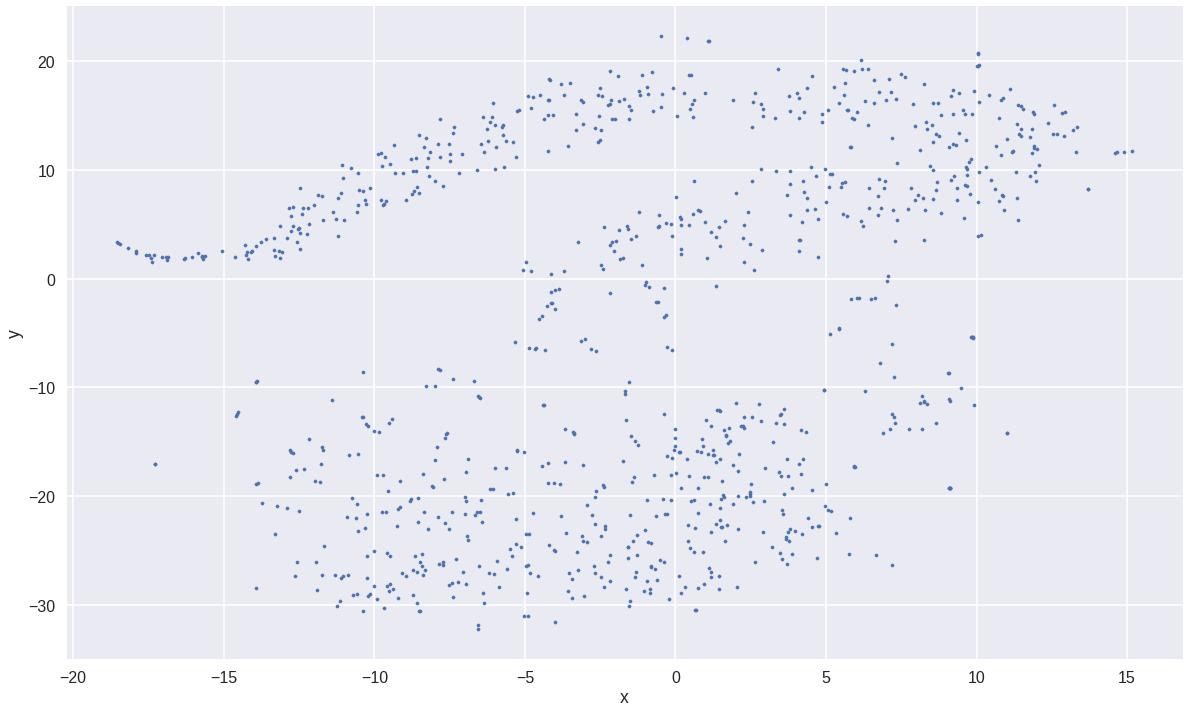

In [107]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [108]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**People related to Kingsguard ended up together**

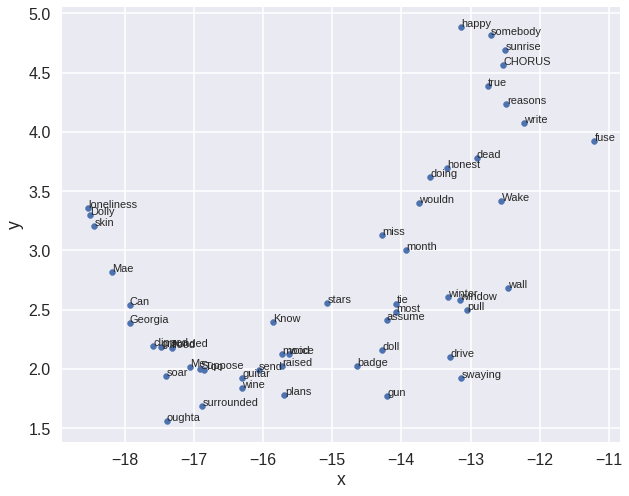

In [109]:
plot_region(x_bounds=(-20, -10), y_bounds=(-5.3, 5))

**Food products are grouped nicely as well. Aerys (The Mad King) being close to "roasted" also looks sadly correct**

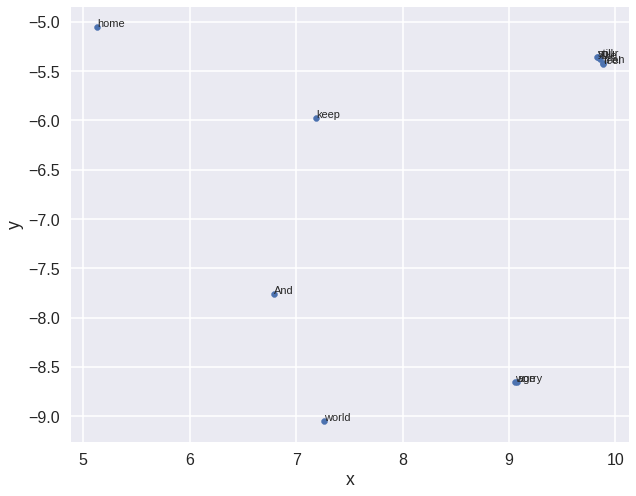

In [110]:
plot_region(x_bounds=(0, 10), y_bounds=(-10, -5))

### Explore semantic similarities between lyrics

**Words closest to the given word**

In [111]:
w2vec.most_similar("gravity")

2017-11-24 08:41:39,363 : INFO : precomputing L2-norms of word weight vectors


[('throw', 0.999792218208313),
 ('lines', 0.9997827410697937),
 ('numbers', 0.999781608581543),
 ('leaving', 0.9997715950012207),
 ('Finish', 0.999770998954773),
 ('Trying', 0.9997696280479431),
 ('sometimes', 0.999768078327179),
 ('maybe', 0.9997661113739014),
 ('photograph', 0.9997660517692566),
 ('Our', 0.9997633695602417)]

In [112]:
w2vec.most_similar("fire")

[('scared', 0.9997243285179138),
 ('set', 0.9996827840805054),
 ('okay', 0.9996781349182129),
 ('train', 0.9996492862701416),
 ('mad', 0.9996298551559448),
 ('easy', 0.9996278285980225),
 ('trying', 0.9996153116226196),
 ('swear', 0.999596357345581),
 ('said', 0.9995938539505005),
 ('mean', 0.9995778203010559)]

In [113]:
w2vec.most_similar("love")

[('who', 0.9964717626571655),
 ('Who', 0.9960875511169434),
 ('you', 0.9824830293655396),
 ('hold', 0.9717382192611694),
 ('want', 0.9689950346946716),
 ('can', 0.9671263098716736),
 ('head', 0.9665601849555969),
 ('dreaming', 0.9659461379051208),
 ('make', 0.9652764797210693),
 ('Oh', 0.9646962881088257)]

**Linear relationships between word pairs**

In [114]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = w2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [115]:
nearest_similarity_cosmul("gravity", "dreams", "city")
nearest_similarity_cosmul("love", "can", "heart")
nearest_similarity_cosmul("fire", "train", "woman")

gravity is related to dreams, as Lydia is related to city
love is related to can, as half is related to heart
fire is related to train, as oh is related to woman


'oh'